In [1]:
import os
from functools import partial
from itertools import product

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.ml_models import OutlierDataset

%reload_ext autoreload
%autoreload 2

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from NEExT.experiment_utils.data_loading import initialize_graph, semi_supervised_set
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.experiment_utils.models import score_unlabeled_gt
from NEExT.ml_models import CosineOutlierDetector
from pygod.utils import load_data

dataset = load_data('inj_cora')

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [13]:
# any outlier
y_target = np.where(dataset.y >0, 1, 0)

edges_df = pd.DataFrame(dataset.edge_index.T)
edges_df.columns = ["src_node_id", "dest_node_id"]

features_df = pd.DataFrame(dataset.x)
features_df.columns = [f'x_{i}' for i in range(dataset.x.shape[1])]

features_df['is_outlier'] = y_target
features_df.insert(0, 'node_id', list(range(len(features_df))))

ground_truth_df = pd.DataFrame()
ground_truth_df['node_id'] =list(range(len(features_df)))
ground_truth_df['is_outlier'] = y_target


features_df = semi_supervised_set(features_df, hide_frac={0:1, 1:1})

mapping_df = pd.DataFrame()
mapping_df['node_id'] =list(range(len(features_df)))
mapping_df['graph_id'] = 0

In [14]:
graph_io = GraphIO()
graph_data= {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [f'x_{i}' for i in range(dataset.x.shape[1])]
}

In [ ]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=2, feature_list=graph_data["feature_list"])

Process ForkPoolWorker-18:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-20:
Process ForkPoolWorker-16:
Process ForkPoolWorker-17:
Process ForkPoolWorker-27:
Process ForkPoolWorker-28:
Process ForkPoolWorker-14:
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/quak/miniconda3/envs/neext/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/quak/miniconda3/envs/neext/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/quak/miniconda3/envs/neext/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/quak/miniconda3/envs/neext/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*s

In [6]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy='structural_embedding',
    structural_embedding_dimension=13,
    feature_embedding_dimension=1,
    embedding_algorithm='approx_wasserstein'
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

<Axes: xlabel='graph_id', ylabel='emb_3_struct'>

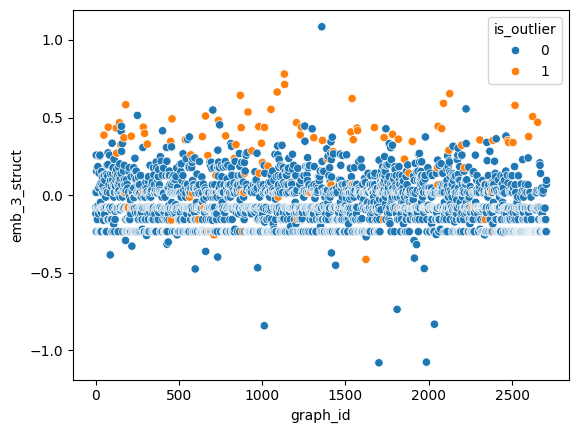

In [7]:
import seaborn as sns
sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 0], y=embeddings.embeddings_df.iloc[:, 4], hue=ground_truth_df['is_outlier'])

In [8]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

for i in [i*10 for i in [0.1, 0.2, 0.3, 1, 5, 10, 15]]:
    scaler = StandardScaler(with_mean=False)
    detector = LocalOutlierFactor(n_neighbors=int(i))
    y_pred = detector.fit_predict(scaler.fit_transform(dataset.X_unlabeled))
    s = roc_auc_score(ground_truth_df['is_outlier'], y_pred)
    print(i, s)
for i in [i*10 for i in [0.1, 1, 5, 10, 15, 100]]:
    scaler = StandardScaler(with_mean=False)
    detector = IsolationForest(n_estimators=int(i))
    y_pred = detector.fit_predict(scaler.fit_transform(dataset.X_unlabeled))
    s = roc_auc_score(ground_truth_df['is_outlier'], y_pred)
    print(s)

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sk

1.0 0.45027350138160493
2.0 0.4559634579597361
3.0 0.4703349687024192
10 0.49803191789319345
50 0.45645406868550165


/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


100 0.31631703603451194
150 0.2832713020921446
0.3516776631139683
0.2856284892573169
0.2790870129137766
0.2664410985168894
0.27052670162972986
0.2676084136919867
